In [95]:
from torch_geometric.datasets import KarateClub
from sknetwork.data import karate_club
import scipy.sparse as sp
import networkx as nx
import pickle
import numpy as np
import json
import matplotlib.pyplot as plt

In [67]:
def sample_graph_det(adj_orig, A_pred, remove_pct, add_pct):
    if remove_pct == 0 and add_pct == 0:
        return copy.deepcopy(adj_orig)
    orig_upper = sp.triu(adj_orig, 1)
    n_edges = orig_upper.nnz
    edges = np.asarray(orig_upper.nonzero()).T
    if remove_pct:
        n_remove = int(n_edges * remove_pct / 100)
        pos_probs = A_pred[edges.T[0], edges.T[1]]
        e_index_2b_remove = np.argpartition(pos_probs, n_remove)[:n_remove]
        mask = np.ones(len(edges), dtype=bool)
        mask[e_index_2b_remove] = False
        edges_pred = edges[mask]
    else:
        edges_pred = edges

    if add_pct:
        n_add = int(n_edges * add_pct / 100)
        # deep copy to avoid modifying A_pred
        A_probs = np.array(A_pred)
        # make the probabilities of the lower half to be zero (including diagonal)
        A_probs[np.tril_indices(A_probs.shape[0])] = 0
        # make the probabilities of existing edges to be zero
        A_probs[edges.T[0], edges.T[1]] = 0
        all_probs = A_probs.reshape(-1)
        e_index_2b_add = np.argpartition(all_probs, -n_add)[-n_add:]
        new_edges = []
        for index in e_index_2b_add:
            i = int(index / A_probs.shape[0])
            j = index % A_probs.shape[0]
            new_edges.append([i, j])
        edges_pred = np.concatenate((edges_pred, new_edges), axis=0)
    adj_pred = sp.csr_matrix((np.ones(len(edges_pred)), edges_pred.T), shape=adj_orig.shape)
    adj_pred = adj_pred + adj_pred.T
    return adj_pred

In [68]:
dataset = KarateClub('dataset/KarateClub')

In [69]:
graph = karate_club(metadata=True)
adjacency = graph.adjacency
position = graph.position
labels = graph.labels

In [70]:
adjacency

<34x34 sparse matrix of type '<class 'numpy.bool_'>'
	with 156 stored elements in Compressed Sparse Row format>

In [71]:
adj = sp.find(adjacency)

In [72]:
edge_list = list(zip(list(adj[0]), list(adj[1])))

In [74]:
KarateClubG = nx.Graph(edge_list)

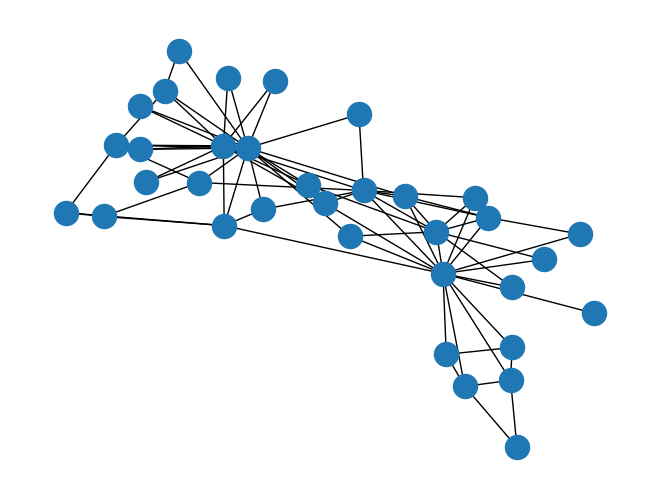

In [75]:
nx.draw(KarateClubG)

In [76]:
params_all = json.load(open('best_parameters.json', 'r'))
params = params_all['GAugM']['KarateClub']['gcn']

In [77]:
params

{'rm_pct': 30, 'add_pct': 34}

In [78]:
probs = pickle.load(open('data/edge_probabilities/KarateClub_graph_2_logits.pkl', 'rb'))
new_adj = sample_graph_det(adjacency, probs, params['rm_pct'], params['add_pct'])

In [84]:
new_adj = sp.find(new_adj)

In [85]:
new_edge_list = list(zip(list(new_adj[0]), list(new_adj[1])))

In [87]:
KarateClubMod = nx.Graph(new_edge_list)

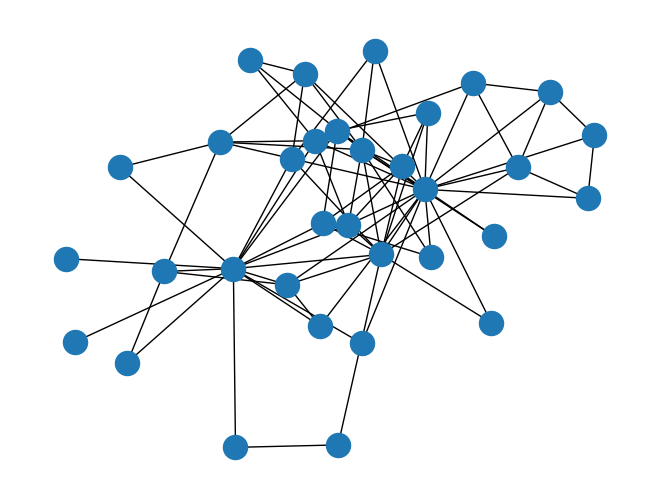

In [88]:
nx.draw(KarateClubMod)

In [90]:
added_edges = []
for edge in new_edge_list:
    if edge not in edge_list:
        added_edges.append(edge)
removed_edges = []
for edge in edge_list:
    if edge not in new_edge_list:
        removed_edges.append(edge)

In [93]:
for edge in added_edges:
    KarateClubMod[edge[0]][edge[1]]['color'] = 'green'
for edge in removed_edges:
    KarateClubMod.add_edge(*edge)
    KarateClubMod[edge[0]][edge[1]]['color'] = 'red'

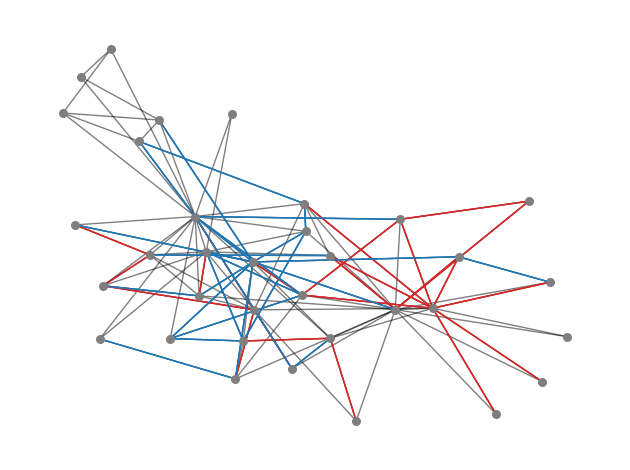

In [104]:
pos = nx.spring_layout(KarateClubMod, seed=3113794652)
nx.draw_networkx_nodes(KarateClubMod, pos, node_color="tab:gray", alpha=1, node_size = 30)
nx.draw_networkx_edges(KarateClubMod, pos, width=1.0, alpha=0.5)
nx.draw_networkx_edges(
    KarateClubMod,
    pos,
    edgelist=removed_edges,
    width=1,
    alpha=1,
    edge_color="tab:red",
)
nx.draw_networkx_edges(
    KarateClubMod,
    pos,
    edgelist=added_edges,
    width=1,
    alpha=1,
    edge_color="tab:blue",
)

plt.tight_layout()
plt.axis("off")
plt.show()